In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
device = torch.device("cpu")

### Defining netwroks with two linear layers. The network reads 3 parameters D_in, H, D_out, where H is the hidden dimension. The linear network works as two matrix multiplication. The first linear layer clamps output at 0 as RELU. The second linear layer output logits.

In [3]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, D_in, H, D_out):    
        super(TwoLayerNet, self).__init__()
        
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [4]:
# N=number of sample, D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
N, D_in, H, D_out = 55, 200, 100, 11
train_mus = range(D_out) # means centered each classification
train_sigma = 0.4 # standard deviation

# test mus step by 0.01 and start 0.5 below the lowest train_mu and end 0.5 above the
# largest train_mu
test_mus = np.arange(min(train_mus)-0.5,max(train_mus)+0.5,0.01)
test_sigma = train_sigma

# this s_factor will be used to scale all values down in the testing and training
# data so that calculations in the model are cleaner. This has shown to improve output
s_factor = 2*max(train_mus)
scale = lambda x: x/s_factor

scaled_train_mus = list(map(scale, train_mus)) 
scaled_train_sigma = scale(train_sigma)
scaled_test_sigma = scale(test_sigma)
scaled_test_mus = list(map(scale,test_mus))

# Learning rate
lr=5e-3
# Number of optimization
num_ops = 40000 

# tensor with inverse weights of target distribution. This means those labels with lower
# values in inv_dist will be upweighted
unimodal = [1,0.75,0.5,0.25,0.125,0,0.125,0.25,0.5,0.75,1]
even = [0,1,0,1,0,1,0,1,0,1,0]
odd = [1,0,1,0,1,0,1,0,1,0,1]
inv_dist = torch.tensor([even for i in range(N)])

# print(inv_dist.shape)

label_mean = 5
label_vals = torch.tensor([[list(range(D_out)) for i in range(N)]])

# Penalty terms
mu_dist = 80 #50
mu_mean = 0 #80

visualize = True

## Predefined data
Each sample is a collection of points centered around a Gaussian distribution. Each sample's points are sorted. The training of the model is performed on scaled down versions of the input for better accuracy in calculations. 

In [5]:
# Input data

X_train = torch.tensor([np.sort(np.random.normal(train_mus[i%D_out], \
                                                    train_sigma, D_in)) for i in range(N)], dtype=torch.float32)
    
X_test = torch.tensor([np.sort(np.random.normal(test_mus[i], \
    test_sigma, D_in)) for i in range(len(test_mus))], dtype=torch.float32)

scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)

y = torch.zeros(N, dtype=torch.long)
# classified to 0,1,2,3,4,5,6,8,9 based on where mean was located initially
for i,x in enumerate(X_train):
    y[i] = round(float(torch.mean(x))) 

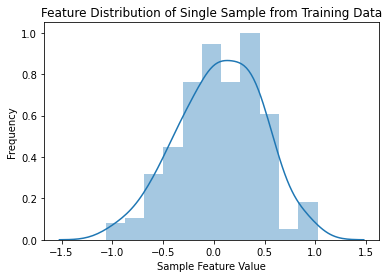

In [6]:
if visualize == True:
    sns.distplot(X_train[0])
    plt.title('Feature Distribution of Single Sample from Training Data')
    plt.xlabel('Sample Feature Value')
    plt.ylabel('Frequency')

X_train shape is: torch.Size([55, 200])


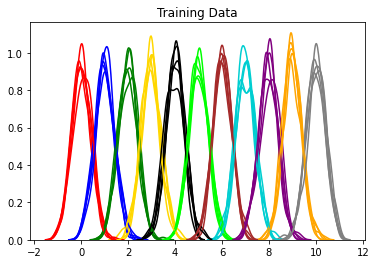

{0: 'red', 1: 'blue', 2: 'green', 3: 'gold', 4: 'black', 5: 'lime', 6: 'brown', 7: 'darkturquoise', 8: 'purple', 9: 'orange', 10: 'gray'}
y shape is: torch.Size([55])
y: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,
         7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
        10])

X_test shape is: torch.Size([1100, 200])


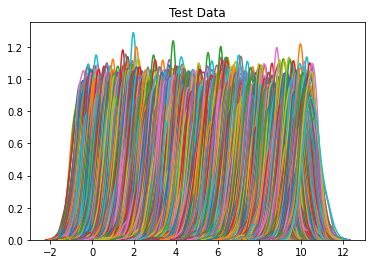

In [7]:
if visualize == True:
    print('X_train shape is:',X_train.shape)

    colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}

    # plots each sample in the training set
    for i, data in enumerate(X_train):
        sns.distplot(data, hist = False, color= colors[i%len(train_mus)]) 

    plt.title('Training Data')
    plt.show()
    print(colors)

    print('y shape is:',y.shape)
    print('y:',y)


    print('\nX_test shape is:',X_test.shape)
    # plots each sample in the testing set
    for x in X_test:
        sns.distplot(x, hist = False)
    # plt.boxplot(X.tolist())
    plt.title('Test Data')
    plt.show()

#### Classification Visualization

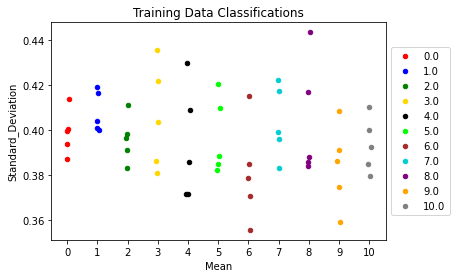

In [8]:
if visualize == True:
    x_samples = []
    # stores the mean, standard deviation, and classification of a sample that will be put in
    # a dataframe for easier visualization
    for i,x in enumerate(X_train):
        x_i = [float(torch.mean(x)),float(torch.std(x)),y[i]]
        x_samples.append(x_i)

    x_samples = np.array(x_samples)

    # Dataframes of samples whose columsn are mean, standard deviation, and classification
    df = pd.DataFrame(dict(Mean=x_samples[:,0], Standard_Deviation=x_samples[:,1], label=x_samples[:,2]))

    colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')

    # Plots the classifications of each sample along with its mean and standard deviation.
    # The classifications should correspond to sample mean and not sample standard deviation
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
    plt.xticks(np.arange(min(train_mus),max(train_mus)+1,1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Training Data Classifications')
    plt.show()

In [9]:
print(X_train.shape)
print(y.shape)
print(X_test.shape)

torch.Size([55, 200])
torch.Size([55])
torch.Size([1100, 200])


### Predefined functions

In [10]:
softmax=torch.nn.Softmax(dim=-1)

### Building model

In [11]:
model = TwoLayerNet(D_in, H, D_out)

loss_fn = nn.CrossEntropyLoss()

### Training

In [13]:
index = []
losses = {'mu_dist':[],'cross_entropy':[],'total':[]}

# performs gradient descent
for i in range(num_ops):
    Y=model(scaled_X_train)
    Y_softmax = torch.softmax(Y, dim = 1)
    dist_penalty = 0.5*mu_dist*torch.mean(Y_softmax*inv_dist)
    cross_entropy = loss_fn(Y,y)
    loss = cross_entropy + dist_penalty
    
    # stores these values for graphing later
    index.append(i)
    losses['cross_entropy'].append(cross_entropy)
    losses['mu_dist'].append(dist_penalty)
    losses['total'].append(loss)
    
    model.zero_grad()
    
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
    
    if i%10000 == 0:
        print('i=',i,'loss.data=',loss.data,'distribution penalty=',dist_penalty)

i= 0 loss.data= tensor(4.0466) distribution penalty= tensor(1.6366, grad_fn=<MulBackward0>)
i= 10000 loss.data= tensor(1.8354) distribution penalty= tensor(0.3862, grad_fn=<MulBackward0>)
i= 20000 loss.data= tensor(1.4655) distribution penalty= tensor(0.3981, grad_fn=<MulBackward0>)
i= 30000 loss.data= tensor(1.2922) distribution penalty= tensor(0.4062, grad_fn=<MulBackward0>)


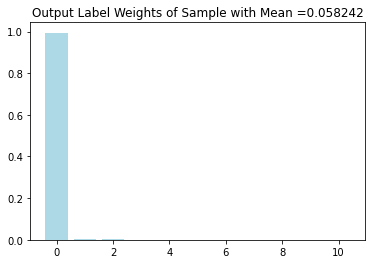

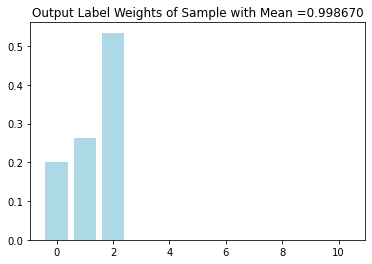

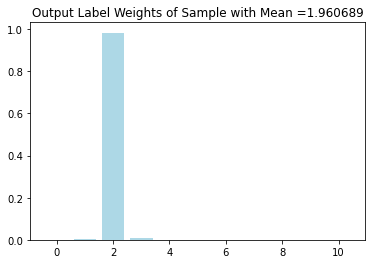

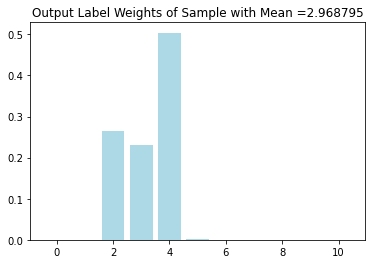

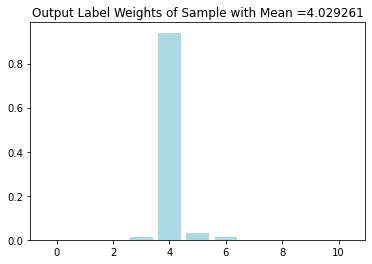

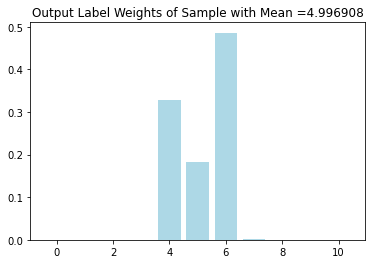

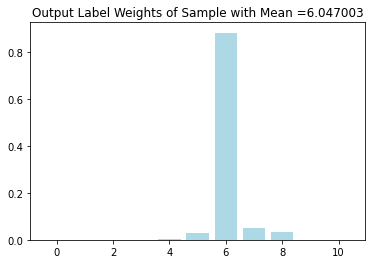

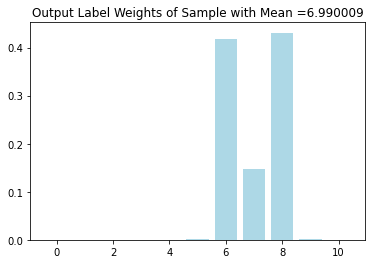

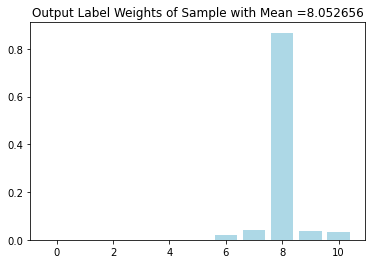

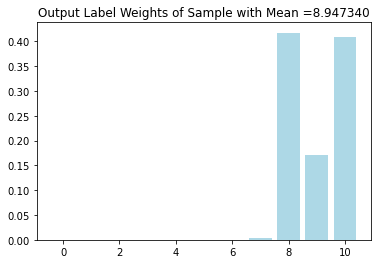

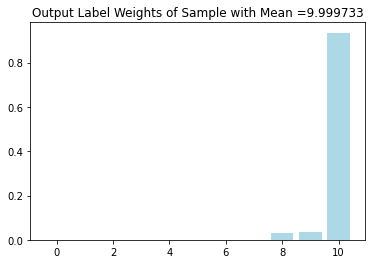

In [14]:
Y_softmax = torch.softmax(Y, dim = 1)
for i in range(D_out):
    plt.bar(range(D_out),Y_softmax[i].detach(), color='lightblue')
    plt.title('Output Label Weights of Sample with Mean =%f'%torch.mean(X_train[i]))
    plt.show()

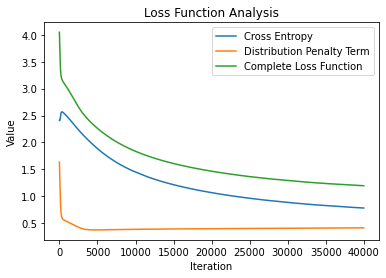

learning rate = 0.005 ; iterations = 40000 ; mu_dist = 80
inv_dist[0] =  tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


In [15]:
plt.plot(index,losses['cross_entropy'], label = 'Cross Entropy')
plt.plot(index,losses['mu_dist'], label = 'Distribution Penalty Term')
plt.plot(index,losses['total'], label = 'Complete Loss Function')
plt.title('Loss Function Analysis')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()
print('learning rate =',lr,'; iterations =',num_ops,'; mu_dist =',mu_dist)
print('inv_dist[0] = ',inv_dist[0])

# Output

### Checking performance of model
The first plot shows the distribution of test data classifications where each test sample is mapped to a particular classification and each classification has a violinplot of which sample means mapped to it.

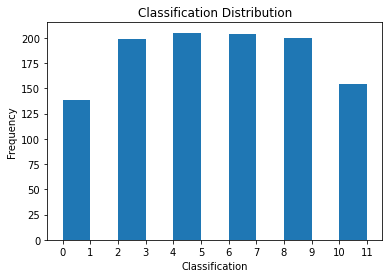

learning rate = 0.005 ; iterations = 40000 ; mu_dist = 80
inv_dist[0] =  tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


In [16]:
Y_test = torch.argmax(softmax(model(scaled_X_test)), axis=1)

bins = range(torch.max(y) + 2)
plt.hist(Y_test, bins=bins)
plt.xticks(bins)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Classification Distribution')
plt.show()

print('learning rate =',lr,'; iterations =',num_ops,'; mu_dist =',mu_dist)
print('inv_dist[0] = ',inv_dist[0])


#### Classification plot
This plot shows each sample's standard deviation and mean and shows which classification it maps to based on its color.

In [17]:
Y_test = torch.argmax(softmax(model(scaled_X_test)), axis=1)
samples = []
# prepares test data for being put into a dataframe
for i,x in enumerate(X_test):
    x_i = [float(torch.mean(x)),float(torch.std(x)),Y_test[i]]
    samples.append(x_i)

samples = np.array(samples)

# test data DataFrame where the 1st column is mean, 2nd is std, and third is classification
df = pd.DataFrame(dict(Mean=samples[:,0], Standard_Deviation=samples[:,1], label=samples[:,2]))

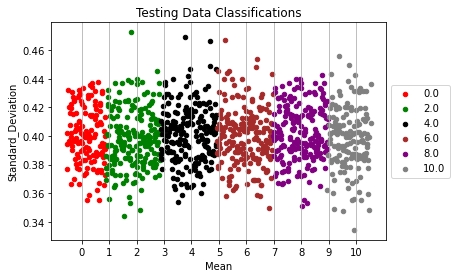

learning rate = 0.005 ; iterations = 40000 ; mu_dist = 80
inv_dist[0] =  tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


In [18]:
colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

# Plots all of the test data samples based on mean and standard deviation and color codes
# its classification
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
plt.xticks(np.arange(min(test_mus)+0.5,max(test_mus),1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Testing Data Classifications')
plt.grid(axis='x')
plt.show()

print('learning rate =',lr,'; iterations =',num_ops,'; mu_dist =',mu_dist)
print('inv_dist[0] = ',inv_dist[0])

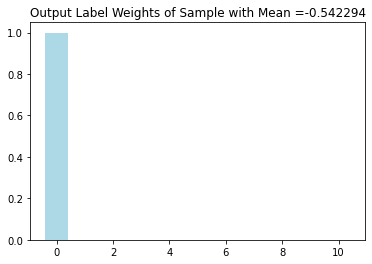

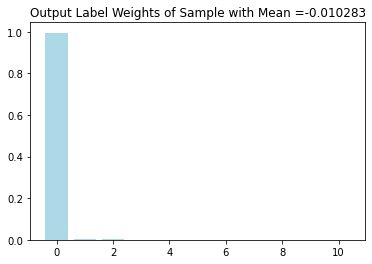

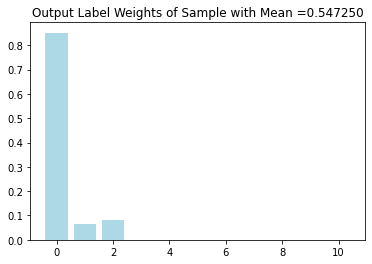

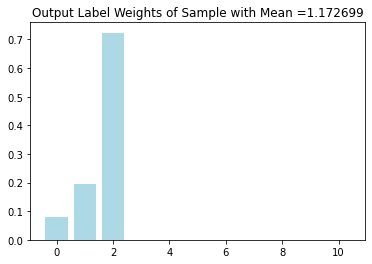

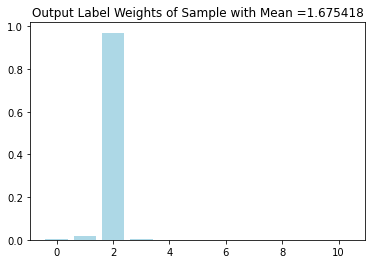

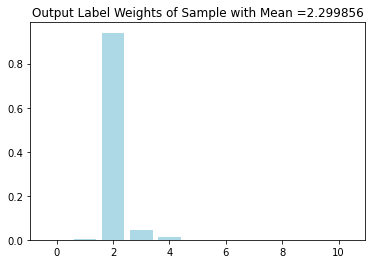

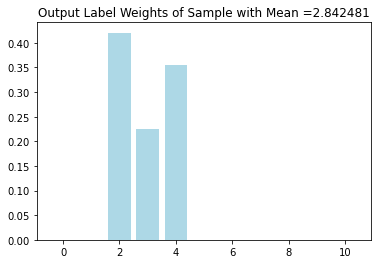

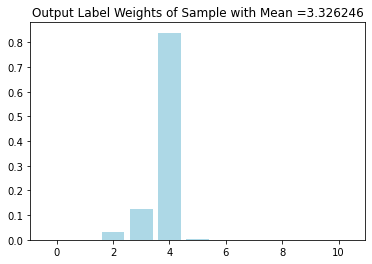

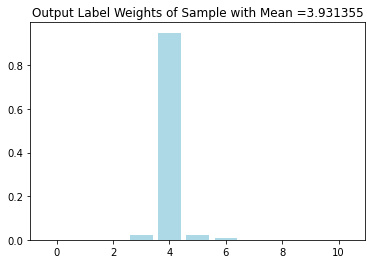

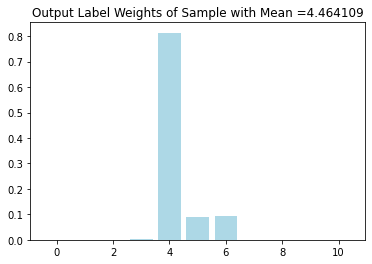

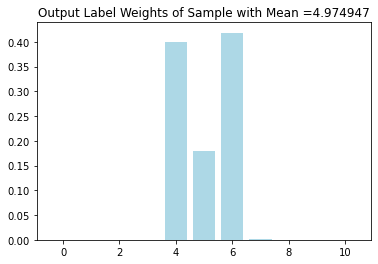

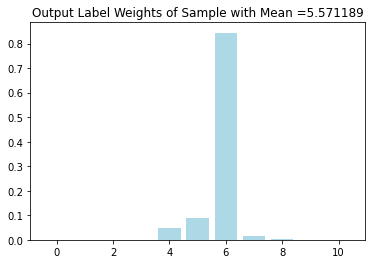

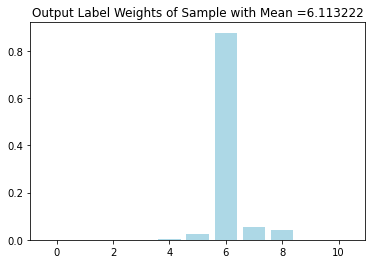

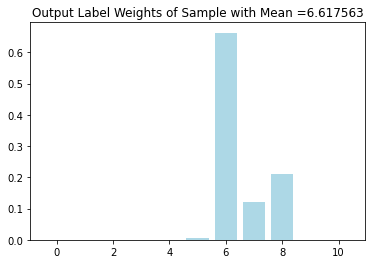

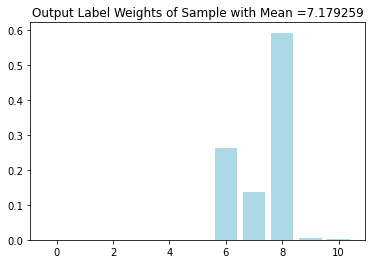

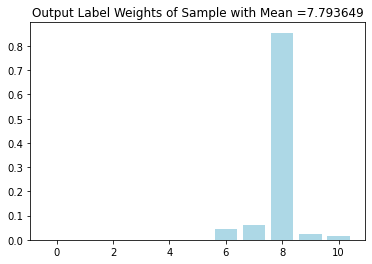

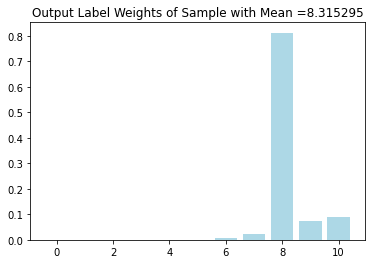

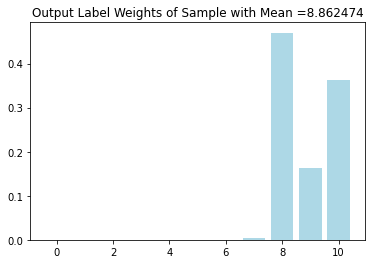

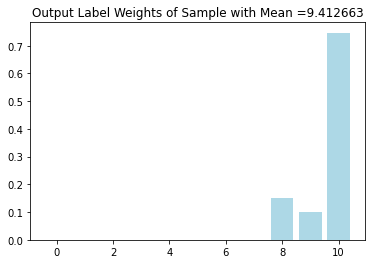

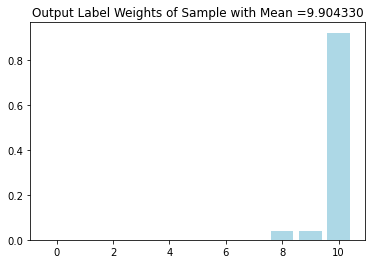

In [25]:
Y_softmax = softmax(model(scaled_X_test))
for i in range(int(D_out*1.9)):
    plt.bar(range(D_out),Y_softmax[i*int(len(test_mus)/20)].detach(), color='lightblue')
    plt.title('Output Label Weights of Sample with Mean =%f'%torch.mean(X_test[i*int(len(test_mus)/20)]))
    plt.show()